# Seasonal Flow Forecasts (SFFs) simulation



Now, we conduct the hydrological forecasts uising Tank model and Seasonal Meteorological Forecasts (SMFs) datasets. This code incorpolates the functions below;


1. <b> [SMFs data generation] </b> Create csv format files combining each ensemble data (precipitation, temperature and evapotranspiration) and convert csv file to the text format which is readable in the Tank model


2. <b> [Tank input data generation </b> Generate the input file of tank model using already estimated parameter and other details, then combine them with SMFs (.txt) data created by the process #1.


3. <b> [Run Tank model] </b> Create batch file for multiple simulation and run.


4. <b> [Output data management] </b> Collect the simulated flow data and save it as csv format. Then integrate the ensemble data at each month.

## 1. SMFs data preparation via  SEAFORM 

Please note that, before we start SFFs (Seasonal Flow Forecasts) simulation, seasonal precipitation (tp; total precipitation), temperature (t2m; 2m temperature) and evapotranspiration (ET; evaporation) forecasts datasets are required as input of hydrological model (Tank). SMFs data management incluing data download, time series generation and bias correction is readily availabe vias our SEAFORM package (SEAsonal FORcast Managment tool, https://github.com/uobwatergroup/seaform.git).

1. Download seasonal forecasts data (p, t, ET) from Copernicus CDS for certain forecasting centre. (SEAFORM module A)
2. Generate daily time series data for each month. (SEAFORM module B)
3. Apply linear scaling, and generate bias corrected time series. (SEAFORM module C)

Place the managed SMFs datasets in relevant folder (original and biascorrected data, refer to the folder path detail shown below '3. Simulation settings').

### 1.1. Import libraries
Now, we need to import the necessary libraries and tools (🚨 in order to run the code like in the box below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [4]:
import os, re
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib.dates as mdates
import datetime
import calendar
from datetime import date
from dateutil.relativedelta import relativedelta
import shutil

### 1.2. Simulation settings

In [3]:
# Specify the provider of Seasonal Meteorological Forecasts
forecast_center = 'ECMWF'

# Assign working directory and time series data
path = os.getcwd()

# Input simulation information
catchment_name = 'A'                  # Define the catchment name
ratio = {'A':0.23, 'B':0.605}         # Ratio of Loss/PET which is defined manually (see hydrologic_data.xlsx)
area = {'A':2073.0, 'B':1584.0}       # Catchment area (square kilometers)
sim_title = catchment_name + '_SFFs'  # Simulation title
loss_et_ratio = ratio[catchment_name] # Call the ET loss ratio defined above for the catchment
catch_area =  area[catchment_name]    # Call the catchment area defined above for the catchment

# model warm up start year (model will start to run from this year Janurary first)
warmup_year = 2009  # model warm up start year (model will start to run from this year Janurary first)

# Define SFFs simulation start and end year/month/day
start_year = 2011
start_month = 1
start_day = 1
start_date = str(start_month).zfill(2) + '/' + str(start_day).zfill(2) + '/' + str(start_year)
end_year = 2020
end_month = 12
end_day = 31
end_date = str(end_month).zfill(2) + '/' + str(end_day).zfill(2) + '/' + str(end_year)

## 2. Tank model input file generation

### 2.1. Read basic input file from ESP

Basic input file (without hydrological data) are the same as ESP, therefore, we just need to bring them to the SFFs folder.

In [5]:
for year in range(start_year, end_year+1):
    for month in range(start_month, end_month+1):
        esp = path + '/analysis/3.ESP/1_input/' + catchment_name + '_' + str(year) + '_' + str(month).zfill(2) + '.txt'
        sffs = path + '/analysis/4.SFFs/1_input/'
        shutil.copy2(esp, sffs)

### 2.2. Generation of Seasoanl Meteorological Forecasts ensemble

Create hydrological ensemble of precipitation, temperature, ET and observed flow data to create the input file of SFFs. Hydrological data of each catchment is shown in /data/ folder. We generate this ensemble scenario every month with multiple SMFs timeseries.

In [6]:
pd.set_option('mode.chained_assignment', None)
folder = {1:'original',2:'biascorrected'}            # Folder names based on the type of bias correction

for bc_type in range(1,3):                           # Bias correction type {1:'before_bc',2:'after_bc'}
    for year in range(start_year, end_year+1):
        for month in range(start_month, end_month+1):
            # specify the number of ensemble of each forecasting centre. This is an example for ECMWF
            # refer to the ensemble size and data availability (for ECMWF, 25 ensemble memebers until 2016 and 50 ensemble from 2017)
            if year > 2016 :
                ens_num = 51
            else :
                ens_num = 25
            # add '_bc' if the data is bias corrected
            if bc_type == 2:
                tail = '_bc'
            else :
                tail = ''
            # read seasonal forecasts data
            tp = pd.read_csv(path + '/data/SMFs/' + forecast_center + '/' + folder[bc_type] + '/tp/' + catchment_name + '_' 
                             + str(year) + '_' + str(month).zfill(2) + '_' + forecast_center.lower() + '_tp' + tail + '.csv')
            t2m = pd.read_csv(path + '/data/SMFs/' + forecast_center + '/' + folder[bc_type] + '/t2m/' + catchment_name + '_' 
                              + str(year) + '_' + str(month).zfill(2) + '_' + forecast_center.lower() + '_t2m' + tail + '.csv')
            et = pd.read_csv(path + '/data/SMFs/' + forecast_center + '/' + folder[bc_type] + '/et/' + catchment_name + '_' 
                             + str(year) + '_' + str(month).zfill(2) + '_' + forecast_center.lower() + '_et' + tail + '.csv')
            # Date format change
            tp['time2'] = pd.to_datetime(tp['time'], infer_datetime_format=True).dt.strftime("%Y-%m-%d")
            merged = pd.DataFrame(data=tp['time2']).rename(columns = {'time2':'time'})

            for i in range(0,ens_num):                            # iteration for all ensemble members
            
                name = 'sc_' + str(i)
                merged['prec'] = round(tp[name],2)                # assign precipitation column
                merged['prec'][merged['prec'] < 0] = 0            # correct negative precipitation data
                merged['ET'] = round(et[name],2)                  # assign ET column
                merged['temp'] = round(t2m[name],2)               # assign temperature column
                # convert the data from dataframe to list
                date = list(merged['time'])
                rain = list(merged['prec'])
                ET = list(merged['ET'])
                temp = list(merged['temp'])
                # create a txt file
                file = open(path + '/analysis/4.SFFs/2_ensemble/' + folder[bc_type] +'/' + catchment_name + '_' + str(year) + '_' + str(month).zfill(2) + '_' + str(i) + '.txt', "w")
                # write the SMFs data in the created txt file        
                for index in range(len(merged)):
                       file.write(str(date[index]).rjust(10) + str(rain[index]).rjust(10) + str(ET[index]).rjust(20) 
                                  + str(temp[index]).rjust(10) + "\n")
                file.close()
print('Ensemble datasets for monthly SFFs are generated!')

Ensemble datasets for SFFs Monthly ESP are created!


### 2.3. Combine the basic input (from 2.1) and ensemble data (from 2.2)

This code enables the combination between the basic simulation input file generated from process 4.1 and ensemble data from process 4.2. When you run this code, you can get the acutal input files for Tank model.

In [8]:
folder = {1:'original',2:'biascorrected'}  # Dictionary mapping for folder types

for bc_type in range(1,3):                          # Loop over bias correction types
    for month in range(start_month, end_month+1):   # Loop over months within the specified range
        for year in range(start_year, end_year+1):  # Loop over years within the specified range
    
            data = data2 = ""                       # Initialize data variables as empty strings
            # Number of ensemble for ECMWF in this case
            if year > 2016: 
                lim = 51  # For years after 2016, ECMWF provides 51 ensemble members
            else:
                lim = 25  # For years up to and including 2016, ECMWF provides 25 ensemble members
        
            for scenario in range(0, lim):  # Loop over the range of scenarios based on the year
  
                # Read basic data generated from 2.1
                with open(path + '/analysis/4.SFFs/1_input/' + catchment_name + '_' + str(year) + '_' + str(month).zfill(2) + '.txt') as fp:
                    data = fp.read()  # Read content of the basic data file
  
                # Read ensemble data generated from 2.2
                with open(path + '/analysis/4.SFFs/2_ensemble/' + folder[bc_type] +'/' + catchment_name + '_' + str(year) + '_' + str(month).zfill(2) + '_' + str(scenario) + '.txt') as fp:
                    data2 = fp.read()  # Read content of the ensemble data file
                
                # Appends the content of data2 to the end of data
                data += data2
                
                # Create merged data by writing the combined content to a new file
                with open (path + '/analysis/4.SFFs/3_run/' + folder[bc_type] +'/' + catchment_name + '_' + str(year) + '_' + str(month).zfill(2) + '_' + str(scenario) + '.txt', 'w') as fp:
                    fp.write(data)  # Write the concatenated data to the new file

print('Now, Tank model input files for SFFs are generated.')  # Print a completion message

Now, Tank model input files for SFFs are generated.


## 3. Run Tank model

Input data for the SFFs simulation has created, and now we run the Tank model for each scenario. For the simulation, 'Sim_SMTank.exe' file should exist in '4.SFFs/3_run' folder.

### 3.1 Batch file generation for the multiple simulation

To run the Tank model with multiple scenarios, this code generates the batch file. We define model name and input and out file names in order.

In [9]:
folder = {1: 'original', 2: 'biascorrected'}  # Dictionary mapping for folder types

# Allocate the input and output file names
for bc_type in range(1, 3):  # Loop over bias correction types: original (non-bias corrected) and bias-corrected
    
    # Open the batch file for writing in the respective folder
    bat_file = open(path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/run_sffs.bat', "w")
    
    for year in range(start_year, end_year + 1):  # Loop over years within the specified range
        for month in range(1, 13):  # Loop over all months (January to December)
            if year > 2016: 
                lim = 51  # Number of ensemble members after 2016 (ECMWF)
            else:
                lim = 25  # Number of ensemble members up to and including 2016 (ECMWF)
        
            for scenario in range(0, lim):  # Loop over the range of scenarios based on the year
                # Write the command to the batch file
                bat_file.write(
                    str('Sim_SMTank') + " " + 
                    catchment_name + '_' + str(year) + '_' + str(month).zfill(2) + '_' + str(scenario) + '.txt' + " " + 
                    catchment_name + '_' + str(year) + '_' + str(month).zfill(2) + '_' + str(scenario) + '.out' + "\n"
                )
    
    # Close the batch file after writing all commands
    bat_file.close()

# Print a completion message
print('The batch file to run Tank model for SFFs is generated.')

Now, Tank model input files for SFFs are generated.


### 3.2 Execute batch file to run Tank model

Now, we run the Tank model using batch file that we have just made. If your are working with multiple years and months, it will take quite long time to terminate the whole simulation.

In [12]:
# set working directory and batch file
for bc_type in range(1, 3):  # Loop over bias correction types: original (non-bias corrected) and bias-corrected
    workingDir = (path + '/analysis/4.SFFs/3_run/' + folder[bc_type])  # Set the working directory based on bias correction type
    executeFile = (path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/run_sffs.bat')  # Set the path to the batch file to execute

    # Define a function to change directory and run the batch file
    def run(path):
        os.chdir(workingDir)  # Change the current working directory to the specified path
        os.system(path)       # Execute the system command (batch file) specified by the path

    # Run the batch file
    run(executeFile)

# Print a completion message
print('Tank model simulation has completed!')

Tank model simulation has completed!


## 4. Output data management

Simulation for ESP has terminated, and now it is time to manage the output data. 

### 4.1 Select simulated flow data form output files

Output file contains diverse kinds of information such as precipitation, temperature and simulated flow. What we need is date and simulated flow. This code enables simulated flow data selection and add date information, then save the selected data to a csv file format.

Note that, the unit of simulated flow is Cubic Meters per Second (CMS).

In [16]:
for bc_type in range(1, 3):  # Loop over bias correction types: original (non-bias corrected) and bias-corrected
    for year in range(start_year, end_year + 1):  # Loop over years within the specified range
        for month in range(start_month, end_month + 1):  # Loop over months within the specified range
            
            if year > 2016: 
                lim = 51  # Number of ensemble members after 2016 (ECMWF)
            else:
                lim = 25  # Number of ensemble members up to and including 2016 (ECMWF)
                
            for scenario in range(0, lim):  # Loop over the range of scenarios based on the year
                # Calculate data gap between the warm-up start date and the start of simulation
                gap = datetime.datetime(year, month, 1) - datetime.datetime(int(warmup_year), 1, 1)
                # Select the column range (horizontal) for simulated flow data (No need to change this)
                colspecs = [(55, 64)]
                # Select the simulated flow data excluding the unnecessary rows (No need to change this)
                data_sel = pd.read_fwf(
                    path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/' + catchment_name + '_' 
                    + str(year) +  '_' + str(month).zfill(2) +  '_'  + str(scenario) + '.out', 
                    skiprows=48 + gap.days, skipfooter=41, colspecs=colspecs, 
                    names=['Q_sim_' + str(scenario)]
                )
                # Allocate date
                index = pd.date_range(datetime.datetime(year, month, 1), periods=len(data_sel)) 
                data_sel['date'] = index
                data_sel = data_sel.set_index('date').reset_index()
                # Save the selected data as CSV format
                new_csv_file = data_sel.to_csv(
                    path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/' + catchment_name + '_' 
                    + str(year) +  '_' + str(month).zfill(2) +  '_'  + str(scenario) + '.csv'
                )
print('Data selection is completed!')

Data selection is completed!


### 4.2 Monthly ensemble integration

By the previous process, we generated the ensemble of simulated flow for each month. However, there are too many datasets to deal with and it is not efficient to manage the data. Therefore, we need to integrate every ensemble at each month.

In [17]:
for bc_type in range(1, 3):  # Iterate over bias correction types: original and bias-corrected
    for year in range(start_year, end_year+1):  # Iterate over the range of years
        for month in range(start_month, end_month+1):  # Iterate over the range of months

            # Read the observed flow data
            obs_flow = pd.read_csv(path + '/data/' + catchment_name + '_hydrologic_data.csv')
            obs_flow['date'] = obs_flow['date'].astype('datetime64[ns]')  # Convert date column to datetime type
        
            # Read the first year data for scenario 0 to use it as the first column
            df_head = pd.read_csv(path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/' + catchment_name + '_' 
                                  + str(year) + '_' + str(month).zfill(2) + '_' + str(0) + '.csv')
            df_head['date'] = df_head['date'].astype('datetime64[ns]')  # Convert date column to datetime type

            # Insert lead time column
            df_head['leadtime'] = df_head['date'].dt.month - month + 1 + 12 * (df_head['date'].dt.year - year)
            df_head = df_head.iloc[:, [0, 1, 3, 2]]  # Reorder columns

            # Set the limit for the number of ensemble scenarios based on the year
            if year > 2016: 
                lim = 51  # Number of ensembles after 2016 (ECMWF)
            else:
                lim = 25  # Number of ensembles before or in 2016 (ECMWF)

            # Fill the next ensemble data
            for scenario in range(1, lim):
                # Read simulated flow data for each scenario
                df = pd.read_csv(path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/' + catchment_name + '_' 
                                 + str(year) + '_' + str(month).zfill(2) + '_' + str(scenario) + '.csv')
                df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, format='%m/%d/%Y', errors='ignore')
                df_head[scenario] = df.iloc[:, 2]  # Append the simulated flow data to df_head
                   
            del df_head['Unnamed: 0']  # Delete unnecessary column
            df_head.rename(columns={'Q_sim_0': 0}, inplace=True)  # Simplify the column name
            
            # Insert forecasted mean column
            df_head['mean'] = round(df_head.loc[:, 0:].mean(axis=1), 2)
            
            # Insert observed flow column
            df_head['obs'] = np.nan  # Initialize the observed flow column with NaN values
            # Fill the observed flow column with data from obs_flow
            df_head['obs'] = np.where(df_head['obs'].isna(), 
                                      df_head['date'].map(obs_flow.set_index('date')['obs_flow']), 
                                      df_head['obs']) 
            df_head.set_index('date', inplace=True)
            
            # Save the integrated ESP ensemble datasets to CSV format
            df_head.to_csv(path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/[out]' + catchment_name + '_' 
                           + str(year) + '_' + str(month).zfill(2) + '.csv')

print('Monthly SFFs simulation ensemble datasets are created!')

Monthly SFFs simulation ensemble datasets are created!


## 5. Visualisation

When you are interested to check the time-series of SFFs including ensemble members, ensemble mean, observed data, this code enables you to visualise it every month. These graphs show accumulated precipitation as an example.

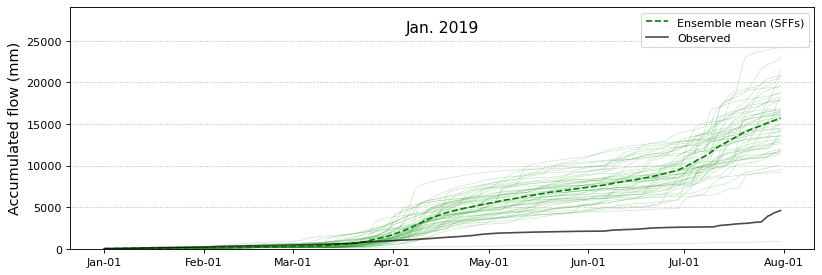

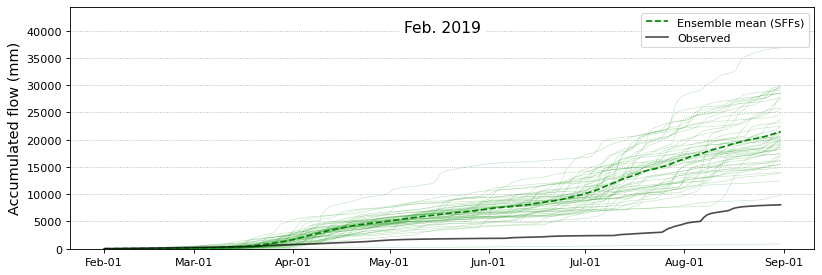

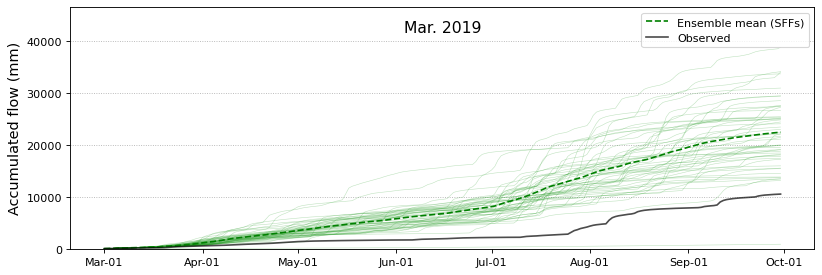

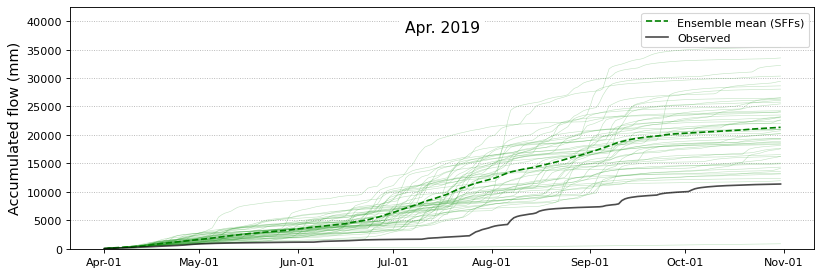

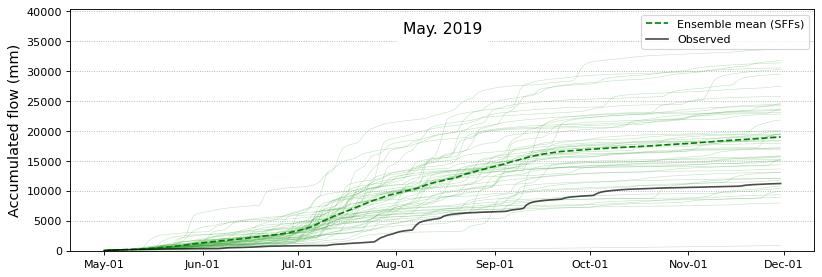

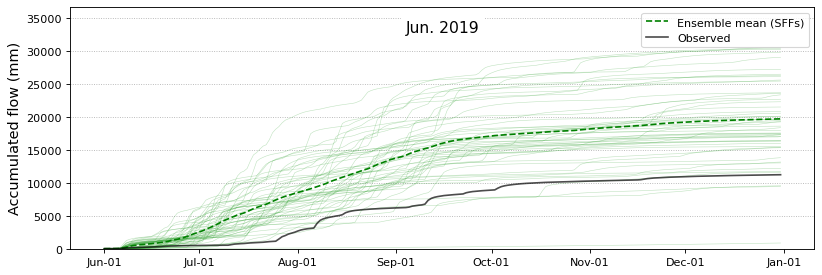

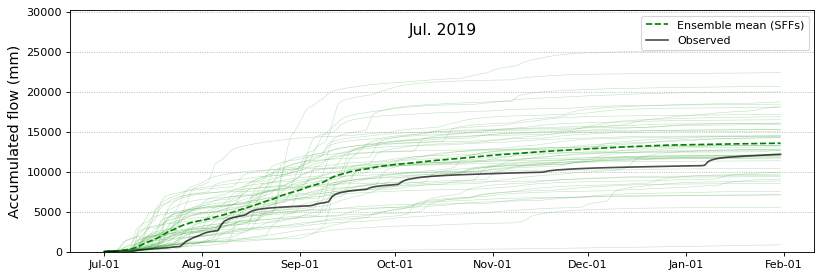

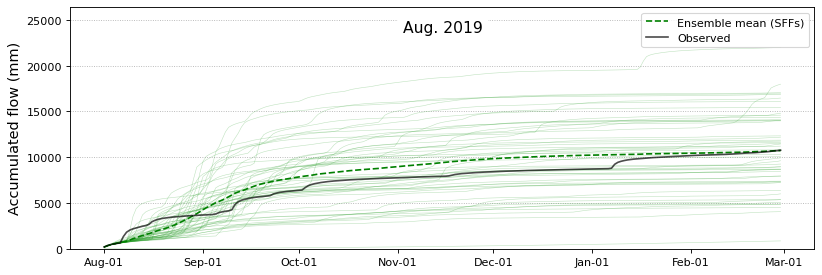

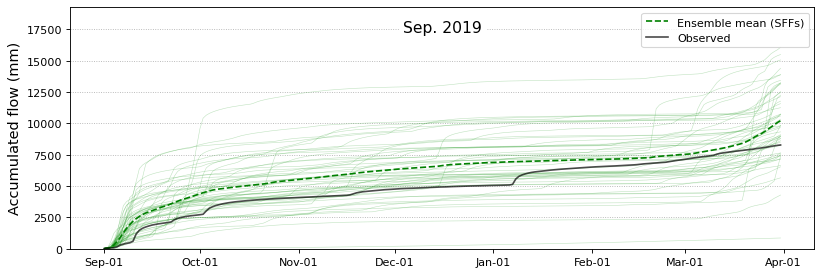

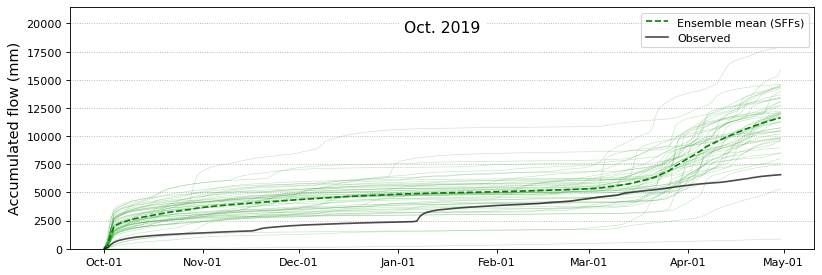

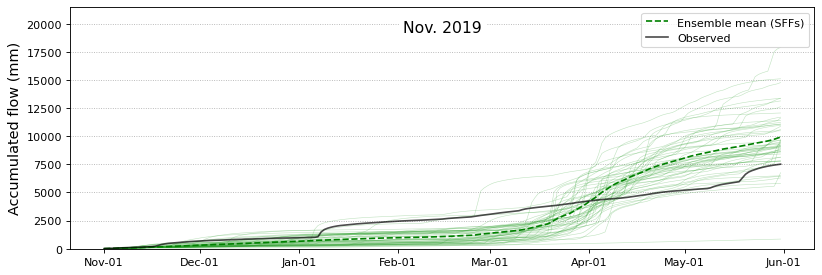

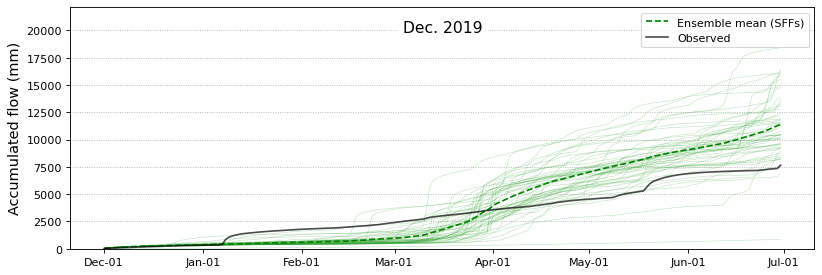

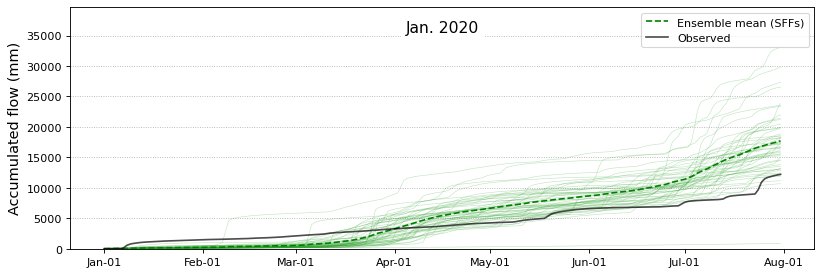

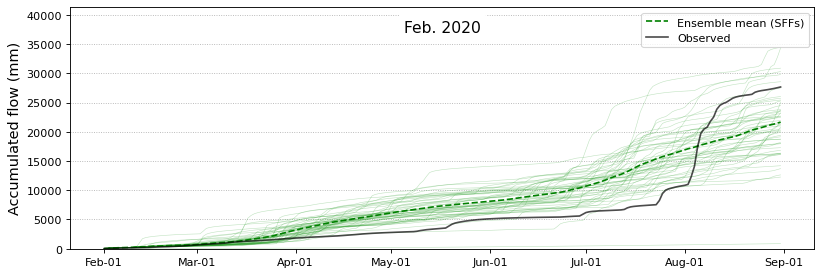

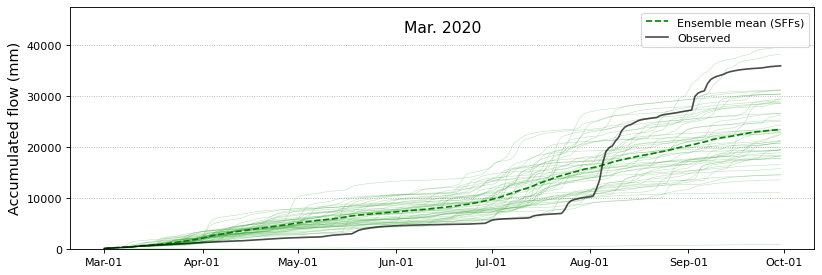

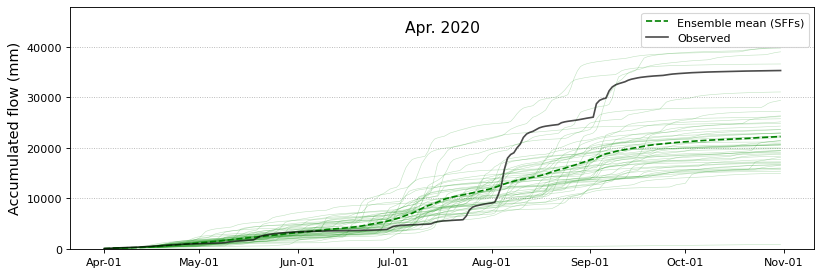

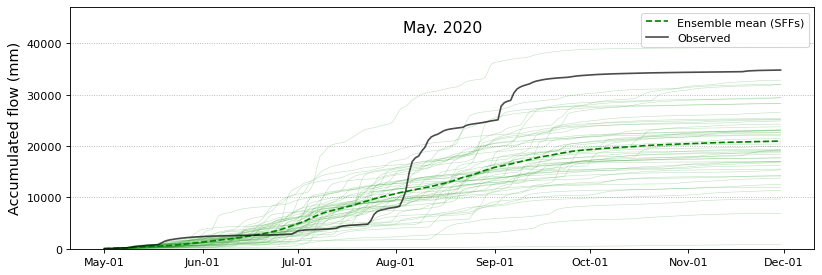

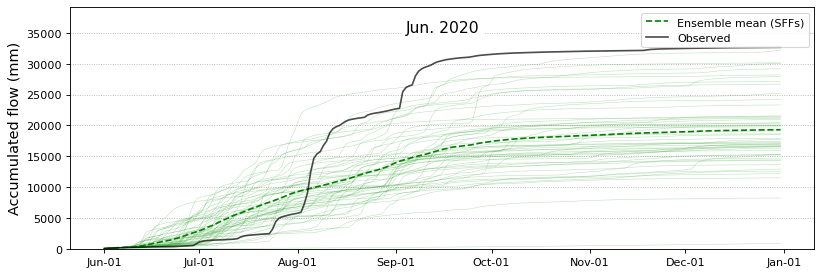

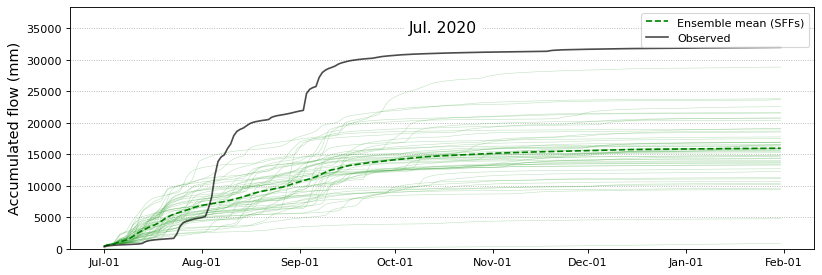

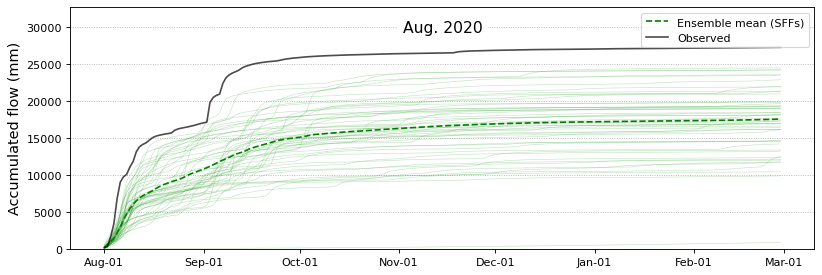

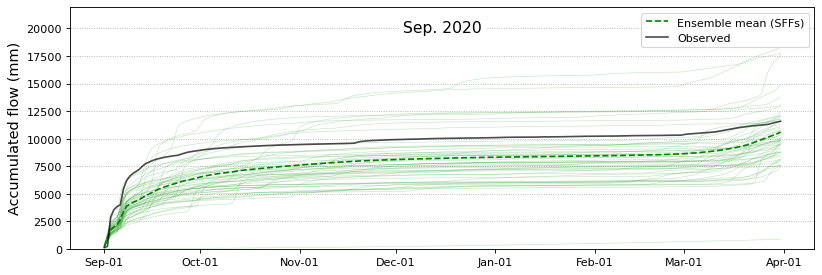

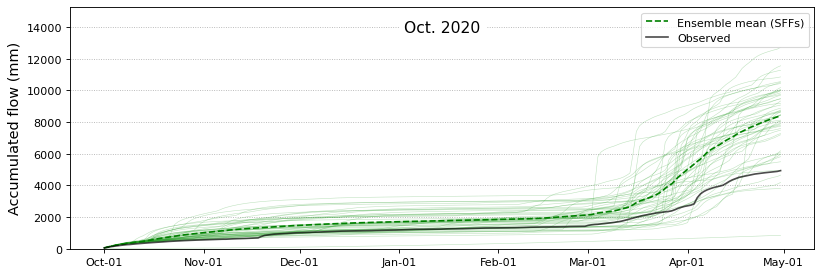

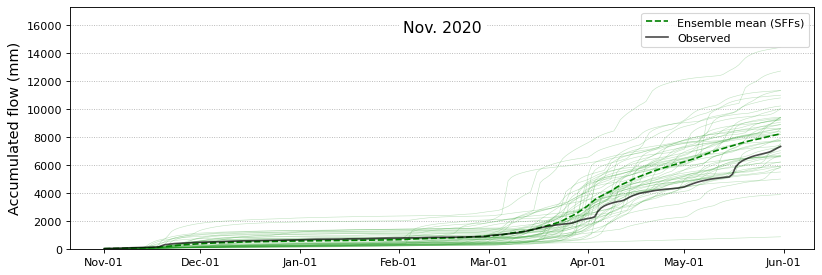

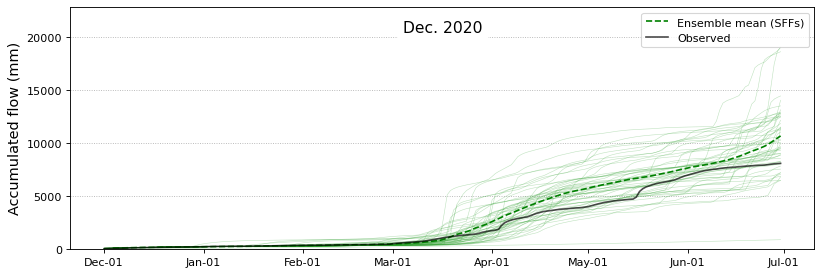

In [28]:
# Define the type of data that you want to visualise
folder = {1: 'original', 2: 'biascorrected'}
bc_type = 1 
# Define the start and end year of visualisation
graph_start_year = 2019
graph_end_year   = 2020

# Loop over each year within the specified range
for years in range(graph_start_year, graph_end_year + 1):
    
    # Loop over each month within the specified range
    for months in range(start_month, end_month + 1):
        
        # Import SFFs Data
        df = pd.read_csv(path + '/analysis/4.SFFs/3_run/' + folder[bc_type] + '/[out]' + catchment_name + '_' 
                         + str(years) + '_' + str(months).zfill(2) + '.csv')
        # Convert 'date' column to datetime format
        df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, format='%m/%d/%Y', errors='ignore')

        # Define the upper limit, lower limit, interval of Y axis and colors
        y_LL = 0                                                # y-axis lower limit
        y_UL = int(np.cumsum(df.iloc[:, 1:]).max().max()*1.2)   # y-axis upper limit, rounded to the nearest thousand
        
        # Draw Plot and Annotate
        fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=80)    

        columns = df.columns[1:]                                # Get all columns except 'date'
        num_columns = len(df.columns) - 1                       # Number of forecast ensemble members (excluding 'date', 'mean', and 'obs')
        mycolors = ['tab:green'] * num_columns                  # List of colors for each ensemble member, initially set to 'tab:green'
                    
        # Plot each forecast ensemble member
        for i, column in enumerate(columns[:-2]):
            plt.plot(df.date.values, np.cumsum(df[column].values), lw=0.5, color=mycolors[i], alpha=0.3)
        
        # Plot the ensemble mean (SFFs) with dashed line
        plt.plot(df.date.values, np.cumsum(df['mean'].values), lw=1.5, ls='--', color='green', alpha=1, label='Ensemble mean (SFFs)')
        
        # Plot the observed flow with solid line
        plt.plot(df.date.values, np.cumsum(df['obs'].values), lw=1.5, color='black', alpha=0.7, label='Observed')

        # Decorations    
        plt.tick_params(axis="both", which="both", bottom=True, top=False, left=True, right=False, 
                        labelbottom=True, labelleft=True, length=4)  # Set tick parameters
        
        plt.grid(True, axis='y', linestyle=':')  # Add grid lines for y-axis

        dateFmt = mdates.DateFormatter('%b-%d')   # Define date format
        ax.xaxis.set_major_formatter(dateFmt)     # Set date format for x-axis
        
        # Title format including month abbreviation and year
        plt.title(calendar.month_abbr[months] + '. ' + str(years), x=0.5, y=0.87, fontsize=14, backgroundcolor='white')
        
        # Set y-axis ticks and labels
        plt.ylabel('Accumulated flow (mm)', fontsize=13)  # Label for y-axis

        plt.legend()  # Display legend
        plt.ylim(y_LL, y_UL)  # Set y-axis limits
        
        plt.show()  # Display the plot